In [1]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.CRITICAL)

In [2]:
import nltk
# nltk.download("stopwords")
# nltk.download("wordnet")

In [3]:
import pandas as pd
tweets_csv = pd.read_csv("data/twcs.csv")
tweets_csv.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0


First I tried to analyze single tweets but it turned out to be unmanagable on my computer and also harmful since tf-idf's tf values will almost always be 1s thus rendering it worthless. So I arranged single tweets into "conversations" using <i>in_response_to_tweet_id</i> and added a <i>channel</i> column referring to the brand (Amazon, Uber, etc.). In this format 1 document is 1 conversation. Documents now have a fair chance of having a meaningful term frequency and it also reduces sample size making it possible to iterate more.

In [4]:
import numpy as np

tweets = tweets_csv.copy()

first_mask = tweets.in_response_to_tweet_id.isnull()
first_tweet_ids = tweets.loc[first_mask, "tweet_id"].values
tweet_conversation = pd.DataFrame({"tweet_id": first_tweet_ids, 
                                   "conversation_id": np.arange(first_tweet_ids.size) + 1}, 
                                  dtype="int64")

unmatched_tweets = tweets.loc[~first_mask, ["tweet_id", "in_response_to_tweet_id"]].astype("int64")

results = tweet_conversation.copy()

while not tweet_conversation.empty:
    merged = pd.merge(unmatched_tweets, tweet_conversation, how="left", left_on="in_response_to_tweet_id", right_on="tweet_id", 
                      suffixes=("", "_parent"))
    matched_mask = merged.tweet_id_parent.notnull()
    tweet_conversation = merged.loc[matched_mask, tweet_conversation.columns]
    results = results.append(tweet_conversation.copy(), ignore_index=True)
    unmatched_tweets = merged.loc[~matched_mask, unmatched_tweets.columns]

results["conversation_id"] = results.conversation_id.astype("int64")

tweets = pd.merge(tweets, results, on="tweet_id")

channels = tweets[~tweets.author_id.str.match(r"[0-9]+$")].groupby("conversation_id")["author_id"].first().to_frame("channel")
tweets = pd.merge(tweets, channels, left_on="conversation_id", right_index=True)

tweets.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,conversation_id,channel
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0,1,sprintcare
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0,1,sprintcare
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0,1,sprintcare
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0,1,sprintcare
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0,1,sprintcare


I decided to analyze a single channel partly because of the finite amount of computational resources I have and also I found it more natural to formulate the problem this way while still working with a realistic scenario.

In [5]:
channel_name = "AskSeagate"
channel_tweets = tweets[tweets.channel == channel_name].groupby("conversation_id")["text"].apply(lambda s: s.str.cat(sep=" "))
channel_tweets.head()

conversation_id
3385     @119615 Unfortunately, the .nbi files cannot b...
15117    @132587 Hello Joey,\n\nWe are sorry that your ...
15118    @132588 Hello Krista,\n\nUnfortunately we don'...
21238    @139188 Try the number zero instead of the let...
21239    @139189 If you have come to the conclusion tha...
Name: text, dtype: object

This is the preprocessing function that does pretty standard things like stopword and url removal, lemmatization and tokenization using nltk.

In [6]:
from nltk.tokenize import RegexpTokenizer
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
import re

tokenizer = RegexpTokenizer(r"\w+")
lemmatizer = WordNetLemmatizer()
stop = set(stopwords.words('english'))
url_pattern = re.compile(r"https\:\/\/t\.co\/[a-zA-Z0-9]+")
num_pattern = re.compile(r"[0-9]+$")

def get_cleaned_doc(doc):
    cleaned = url_pattern.sub("?", doc)
    cleaned = cleaned.lower()
    cleaned = tokenizer.tokenize(cleaned)
    cleaned = [word for word in cleaned if num_pattern.match(word) is None]
    cleaned = [lemmatizer.lemmatize(word) for word in cleaned]
    cleaned = [word for word in cleaned if word not in stop]
    return cleaned


Actually converting documents and filtering (at least in 2 documents and in no more than 50% of all documents) vocabulary.

In [7]:
from collections import defaultdict
from gensim.corpora import Dictionary

docs = [get_cleaned_doc(doc) for doc in channel_tweets]

dictionary = Dictionary(docs)
dictionary.filter_extremes(no_below=2, keep_n=None)
corpus = [dictionary.doc2bow(doc) for doc in docs]

c:\users\gyorgym\apps\miniconda3\envs\dl\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


First to have an overview of the channel's content I visualized the most important words of the channel using a flattened corpus that is equivalent to term frequency weighting.

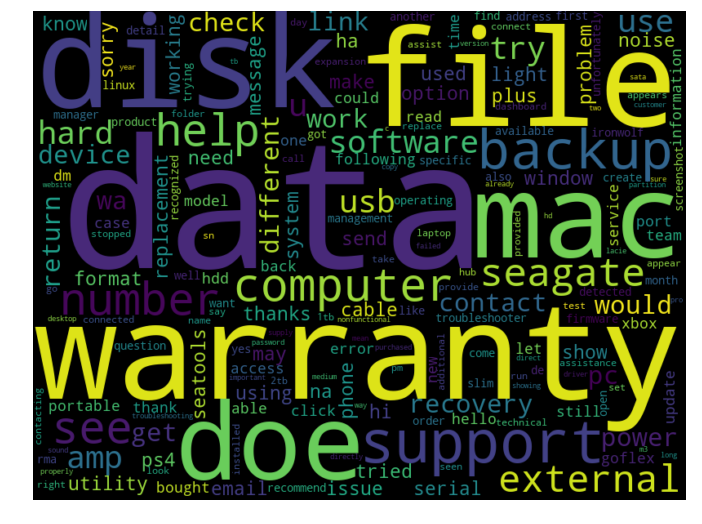

In [8]:
from gensim.models import TfidfModel
from wordcloud import WordCloud
import matplotlib.pyplot as plt

%matplotlib inline

flattened_corpus = [dictionary.doc2bow([token for doc in docs for token in doc])]

tfidf = TfidfModel(flattened_corpus, dictionary=dictionary)
token_imp = dict([(dictionary[token_id], imp) for token_id, imp in tfidf[flattened_corpus][0]])

word_cloud = WordCloud(width=800, height=600).generate_from_frequencies(token_imp)

plt.figure(figsize=(12, 9))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off");


I also created a corpus where each document contains the tweets from a single channel. This time I calculated the classic TF-IDF for my selected channel and visualized it as a word cloud.

In [16]:
all_conversations = tweets.groupby("channel")["text"].apply(lambda s: s.str.cat(sep=" "))
all_docs = [get_cleaned_doc(doc) for doc in all_conversations]
all_dictionary = Dictionary(all_docs)
all_corpus = [all_dictionary.doc2bow(doc) for doc in all_docs]

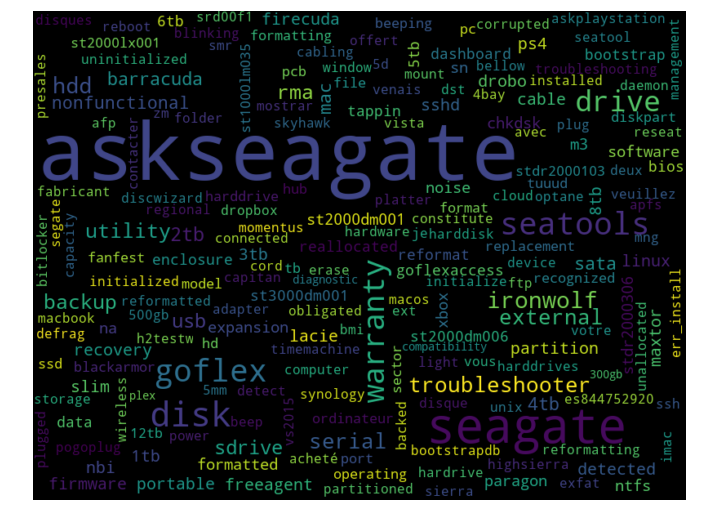

In [17]:
channel_index = np.where(all_conversations.index == channel_name)[0][0]

tfidf = TfidfModel(all_corpus, dictionary=all_dictionary)
token_imp = dict([(all_dictionary[token_id], imp) for token_id, imp in tfidf[all_corpus][channel_index]])

word_cloud = WordCloud(width=800, height=600).generate_from_frequencies(token_imp)

plt.figure(figsize=(12, 9))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off");

Then I tried to identify clusters within the channel using hierarchical clustering with different metrics (cosine and euclidean), clustering methods (single, complete, average, ward) and weighting schemes (some ideas from http://brandonrose.org/clustering). I visualized the result to help select optimal number of clusters. I found that using boolean term frequencies tend to give better results which makes sense since most of the conversations are still short so a term occuring more than once just adds noise but not much meaning.

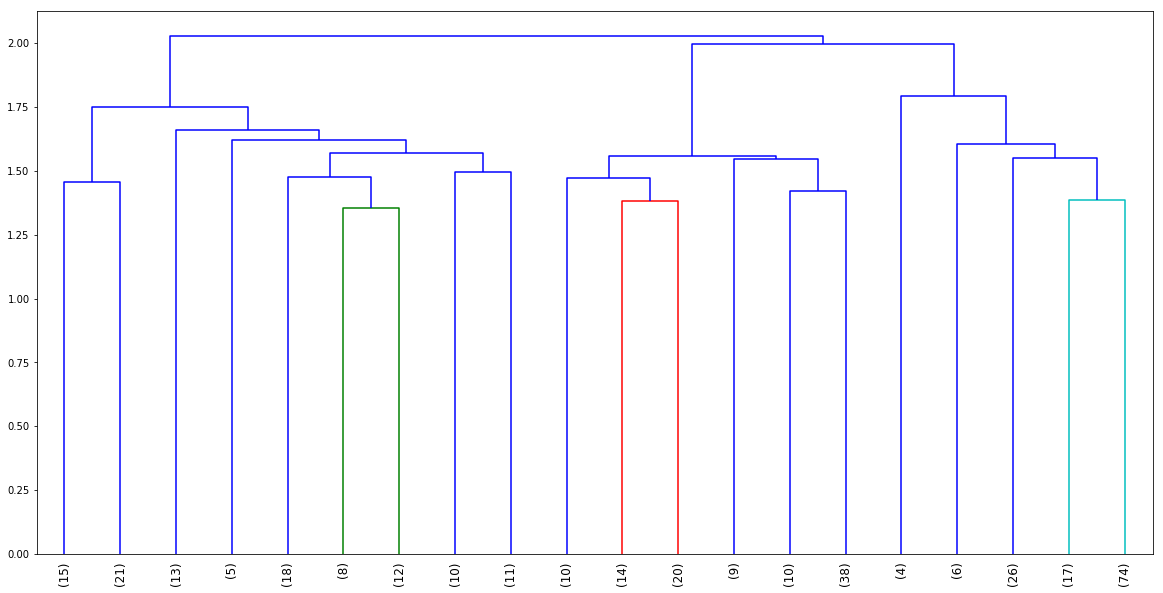

In [9]:
from gensim.matutils import corpus2dense
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage, ward

weighted_corpus = TfidfModel(corpus, dictionary=dictionary, smartirs="btc")[corpus]

dense_corpus = corpus2dense(weighted_corpus, len(dictionary)).T

dist = pdist(dense_corpus, metric="cosine")

Z = linkage(dist, "ward")

plt.figure(figsize=(20, 10))
dendrogram(
    Z,
    leaf_rotation=90.,
    leaf_font_size=12.,
    truncate_mode = "lastp",
    p=20
);


After selecting the number of clusters show top n words for each

In [10]:
from scipy.cluster.hierarchy import fcluster

k = 10
clusters = fcluster(Z, k, criterion='maxclust')

clustered_docs = []

for cidx in range(k):
    cluster_indices = np.where(clusters == cidx + 1)[0]    
    clustered_docs.append([token for i, doc in enumerate(docs) if i in cluster_indices for token in doc])

clustered_dict = Dictionary(clustered_docs)
clustered_corpus = [clustered_dict.doc2bow(doc) for doc in clustered_docs]

tfidf = TfidfModel(clustered_corpus, dictionary=clustered_dict)

top_n = 5

topics = []

for cidx in range(k):
    token_imp = [(clustered_dict[token_id], imp) for token_id, imp in tfidf[clustered_corpus[cidx]]]
    token_imp.sort(key=lambda x: x[1], reverse=True)
    top_words = [token for token, imp in token_imp][:top_n]
    topics.append(top_words)

df = pd.DataFrame(topics)
df.columns.name = "word"
df.index.name = "cluster"
df


word,0,1,2,3,4
cluster,,,,,
0,cable,port,utility,different,usb
1,supply,damaged,electronics,adapter,cable
2,bitlocker,pm,locked,blinking,applied
3,sector,reallocated,fall,serious,month
4,covered,recovery,backing,critical,occasionally
5,email,bootstrap,u,case,technician
6,return,email,phone,order,center
7,de,il,je,votre,un
8,io,app,goflexaccess,browser,home


Showing word cloud for random cluster

Showing cluster 9


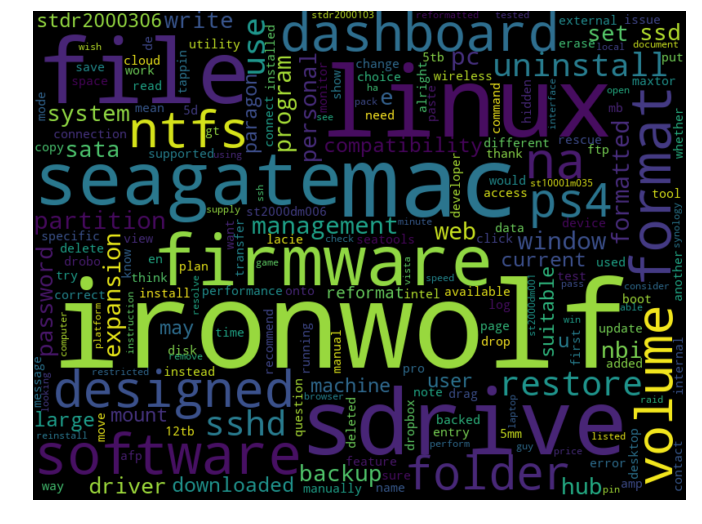

In [11]:
rnd_idx = np.random.randint(len(clustered_corpus))
print("Showing cluster " + str(rnd_idx))

token_imp = dict([(clustered_dict[token_id], imp) for token_id, imp in tfidf[clustered_corpus[rnd_idx]]])

word_cloud = WordCloud(width=800, height=600).generate_from_frequencies(token_imp)

plt.figure(figsize=(12, 9))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off");

I also tried Latent Dirichlet Allocation. Here I turned on debugging to select optimal number of iterations and passes. I use asymmetric, automatically learned priors for alpha as suggested here: https://people.cs.umass.edu/~wallach/publications/wallach09rethinking.pdf and play with different weighting schemes.

In [ ]:
from gensim.models import LdaModel

weighted_corpus = TfidfModel(corpus, dictionary=dictionary, smartirs="nnn")[corpus]

logging.getLogger().setLevel(logging.DEBUG) # checking convergence
lda = LdaModel(weighted_corpus, id2word=dictionary, num_topics=10, alpha='auto', iterations=400, passes=3)
logging.getLogger().setLevel(logging.CRITICAL)

Helper function for evaluating different number of topics by perplexity and coherence using fold cross validation

In [13]:
import random
from gensim.models import LdaModel, LdaMulticore, CoherenceModel

def eval_config(corpus, texts, n_topics, k=10, iterations=100, passes=1, multicore=False):
    def get_lda_model(train_corpus):
        if multicore:
            return LdaMulticore(train_corpus, id2word=dictionary, num_topics=n_topics, iterations=iterations, passes=passes)
        return LdaModel(train_corpus, id2word=dictionary, num_topics=n_topics, alpha='auto', iterations=iterations, passes=passes)
    
    random.shuffle(corpus)
    perps = []
    for i in range(k):
        val_from = round(i / k * len(corpus)) if k > 1 else 0
        val_to = round((i + 1) / k * len(corpus)) if k > 1 else 0
        train = corpus[:val_from] + corpus[val_to:]
        val = corpus[val_from:val_to]
        
        lda = get_lda_model(train)
        perps.append(lda.log_perplexity(val if k > 1 else train))
    
    lda = get_lda_model(corpus)
    umass = CoherenceModel(model=lda, corpus=corpus, coherence='u_mass')
    cv = CoherenceModel(model=lda, texts=texts, coherence='c_v')
    
    return (np.mean(perps), np.std(perps), umass.get_coherence(), cv.get_coherence(), lda)

In [14]:
topic_values = [2, 5, 10, 25, 50, 100]
results = [eval_config(list(weighted_corpus), docs, n_topics, iterations=400, passes=3, k=2) for n_topics in topic_values]

df = pd.DataFrame({"n_topics": topic_values, 
                   "mean perplexity": [result[0] for result in results], 
                   "perplexity sd": [result[1] for result in results], 
                   "umass": [result[2] for result in results], 
                   "c_v": [result[3] for result in results]}, index=topic_values)

df.index.name = "n_topics"
df

c:\users\gyorgym\apps\miniconda3\envs\dl\lib\site-packages\gensim\models\ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


,c_v,mean perplexity,n_topics,perplexity sd,umass
n_topics,,,,,
2,0.316966,-6.874496,2,0.002299,-1.424794
5,0.302758,-7.402473,5,0.006712,-1.545876
10,0.308880,-8.058857,10,0.039733,-2.019940
25,0.305193,-9.390871,25,0.002290,-2.768018
50,0.328690,-11.427056,50,0.029072,-3.982939
100,0.338508,-14.574524,100,0.407050,-4.029262


Visualizng LDA helps better understand topics. By setting relevance to a lower value we can find more relevant words for a topic (the original paper suggests somewhere around 0.6)

In [15]:
import pyLDAvis.gensim

weighted_corpus = TfidfModel(corpus, dictionary=dictionary, smartirs="nnn")[corpus]
lda = LdaModel(weighted_corpus, id2word=dictionary, num_topics=10, alpha='auto', iterations=400, passes=3)

pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda, weighted_corpus, dictionary, mds="tsne")

PreparedData(topic_coordinates=            Freq  cluster  topics           x           y
topic                                                    
1      34.537827        1       1   54.873440 -141.514847
2      13.659602        1       2  -93.566696  -17.823732
9       8.569937        1       3   86.867912  142.973862
0       8.067849        1       4  118.728271   40.865356
3       7.503004        1       5 -118.700905   86.140282
8       7.461483        1       6  -61.729778 -119.934387
4       6.875490        1       7  143.839294  -63.109009
5       6.418640        1       8   -0.478603   58.742619
6       4.246655        1       9   25.631762  -35.703526
7       2.659514        1      10  -29.738323  164.548035, topic_info=     Category        Freq       Term       Total  loglift  logprob
term                                                              
6     Default  138.000000       data  138.000000  30.0000  30.0000
160   Default   60.000000   recovery   60.000000  29.0000  29.0000
42    Default  110.000000     number  110.000000  28.0000  28.0000
76    Default  129.000000   warranty  129.000000  27.0000  27.0000
172   Default  112.000000       disk  112.000000  26.0000  26.0000
109   Default   79.000000       link   79.000000  25.0000  25.0000
222   Default  116.000000       help  116.000000  24.0000  24.0000
24    Default  123.000000    support  123.000000  23.0000  23.0000
2     Default  101.000000     backup  101.000000  22.0000  22.0000
138   Default   93.000000        mac   93.000000  21.0000  21.0000
167   Default  123.000000          u  123.000000  20.0000  20.0000
48    Default   73.000000     serial   73.000000  19.0000  19.0000
187   Default   91.000000      would   91.000000  18.0000  18.0000
753   Default   18.000000   ironwolf   18.000000  17.0000  17.0000
228   Default   56.000000      power   56.000000  16.0000  16.0000
12    Default   96.000000   external   96.000000  15.0000  15.0000
30    Default  101.000000        use  101.000000  14.0000  14.0000
117   Default   56.000000     return   56.000000  13.0000  13.0000
151   Default   95.000000       hard   95.000000  12.0000  12.0000
164   Default   66.000000   software   66.000000  11.0000  11.0000
74    Default  116.000000        try  116.000000  10.0000  10.0000
23    Default   96.000000        see   96.000000   9.0000   9.0000
206   Default   43.000000         dm   43.000000   8.0000   8.0000
34    Default  102.000000   computer  102.000000   7.0000   7.0000
10    Default  125.000000        doe  125.000000   6.0000   6.0000
62    Default  157.000000    seagate  157.000000   5.0000   5.0000
328   Default   58.000000      email   58.000000   4.0000   4.0000
4     Default   81.000000    contact   81.000000   3.0000   3.0000
51    Default   54.000000     system   54.000000   2.0000   2.0000
101   Default   31.000000     goflex   31.000000   1.0000   1.0000
...       ...         ...        ...         ...      ...      ...
565   Topic10    2.078976    request    9.894363   2.0669  -5.1419
482   Topic10    1.716402    receipt    8.186428   2.0648  -5.3335
444   Topic10    2.390964    getting   12.580022   1.9666  -5.0020
160   Topic10    5.565443   recovery   60.732944   1.2371  -4.1572
42    Topic10    7.475962     number  110.120346   0.9371  -3.8620
76    Topic10    8.229525   warranty  129.706818   0.8695  -3.7660
109   Topic10    5.803078       link   79.613960   1.0082  -4.1154
48    Topic10    5.081680     serial   73.495552   0.9554  -4.2481
6     Topic10    6.391915       data  138.305725   0.5526  -4.0187
608   Topic10    2.378021       call   19.328634   1.5317  -5.0075
119   Topic10    3.047449    service   39.333847   1.0692  -4.7594
375   Topic10    1.835097       week   12.827156   1.6826  -5.2666
644   Topic10    2.533736      click   26.502123   1.2795  -4.9440
100   Topic10    3.351073  following   49.613953   0.9320  -4.6645
323   Topic10    2.934988       back   39.339691   1.0315  -4.7970
432   Topic10    1.716401    picture   11.920